In [1009]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [1010]:
words = open("names.txt", 'r').read().splitlines()
characters = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(characters)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [1011]:
# building the training set (remember: all data are represented in number)
block_size = 3
X = []
Y = []
for word in words:
  word += "."
  x = block_size * [0]
  # print(word)
  for char in word:
    y = stoi[char]
    # print(f"{"".join([itos[c] for c in x])} ---> {itos[y]}")
    X.append(x)
    Y.append(y)
    x = x[1:] + [y]

# why do I turn them into tensor?
# bc they start the forward pass and needed to be matrix multiplied
X = torch.tensor(X)
Y = torch.tensor(Y)

In [1012]:
print(X.shape), print(X.dtype), print(Y.shape), print(Y.dtype)

# My splitting solution... but i can't do this because 
# 1) the word list is not random and 
# 2) the possibility of examples of certain pattern like the beginning of a word e.g., [".", ".", "."] congregating should be avoided
# Therefore, we should split the word list instead of the original dataset
# split_1 = int(0.8 * X.shape[0])  # I can't assume torch.Size is a scalar, that's why I need to use shape[0] to access first dimension even for Y
# split_2 = int(0.9 * X.shape[0])  # remembe to make it an int
# Xtr, Ytr = X[:split_1], Y[:split_1]
# Xdev, Ydev = X[split_1:split_2], Y[:split_1:split_2]
# Xte, Yte = X[split_1:], Y[split_1:]

def build_dataset(words):
  block_size = 3
  X = []
  Y = []
  for word in words:
    word += "."
    x = block_size * [0]
    # print(word)
    for char in word:
      y = stoi[char]
      # print(f"{"".join([itos[c] for c in x])} ---> {itos[y]}")
      X.append(x)
      Y.append(y)
      x = x[1:] + [y]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  return X, Y

import random
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([228146, 3])
torch.int64
torch.Size([228146])
torch.int64


In [1013]:
Xtr, Ytr

(tensor([[ 0,  0,  0],
         [ 0,  0,  5],
         [ 0,  5, 12],
         ...,
         [21, 19, 20],
         [19, 20,  9],
         [20,  9, 14]]),
 tensor([ 5, 12,  5,  ...,  9, 14,  0]))

In [1014]:
# defining the embedding matrix C
C = torch.randn((27, 2))
print(C)

tensor([[ 1.1551,  0.7904],
        [ 1.1386, -0.9772],
        [ 0.2315,  1.0457],
        [-2.0389,  0.1272],
        [-0.0222,  0.4795],
        [ 0.4256, -0.2212],
        [-0.5517,  0.7034],
        [ 0.6038, -1.0518],
        [ 1.6930, -0.3529],
        [-1.2518, -0.1494],
        [-0.0536, -1.5129],
        [-1.8383, -0.1515],
        [ 0.0663, -1.5128],
        [ 0.2512,  0.2963],
        [ 0.8135,  0.6877],
        [-0.2484, -0.5110],
        [ 1.3003,  1.1638],
        [ 0.3504,  0.1922],
        [-0.0384,  0.6346],
        [ 0.1960, -0.2765],
        [-0.1588,  1.6116],
        [-1.0640,  0.9192],
        [-0.3400, -0.3336],
        [-0.9567, -0.6890],
        [-1.0174,  0.7999],
        [-0.3995, -1.5035],
        [ 0.8655,  0.5250]])


In [1015]:
# two different interpretations of the embedding layer
# 1. matrix value retrieval
print(C[5])
# 2. a linear layer
print(torch.nn.functional.one_hot(torch.tensor(5), num_classes=27).float() @ C)

tensor([ 0.4256, -0.2212])
tensor([ 0.4256, -0.2212])


In [1016]:
# retrieving multiple embedding values
C[5,6,7,7,7]

IndexError: too many indices for tensor of dimension 2

In [ ]:
# retrieving multiple embedding values
print(C[0])
print(C[[5,6,7,7,7]])  # give it a list when i need to retrieve multiple results at once, and the result is in a nested list too
print(C[X]) # what this is really doing is the addition of C.dim()-1 more dimension
emb = C[X]
emb.shape

tensor([ 1.0833, -1.5884, -2.1256, -0.8095, -0.3438, -0.1761,  2.1422, -0.4139,
        -0.9470, -0.6801], grad_fn=<SelectBackward0>)
tensor([[-1.1422, -0.3441,  0.0879, -0.3628,  0.0296,  1.3794,  0.1016,  0.6090,
          0.3779,  0.0466],
        [ 3.1942,  0.8209, -0.2246,  1.1427, -0.4684,  4.4187, -1.2241, -3.0324,
          0.8033, -1.1875],
        [-0.1132, -0.0658, -0.0536, -0.4548,  0.7261, -0.5879, -0.1529, -0.6579,
         -0.0797,  0.4862],
        [-0.1132, -0.0658, -0.0536, -0.4548,  0.7261, -0.5879, -0.1529, -0.6579,
         -0.0797,  0.4862],
        [-0.1132, -0.0658, -0.0536, -0.4548,  0.7261, -0.5879, -0.1529, -0.6579,
         -0.0797,  0.4862]], grad_fn=<IndexBackward0>)
tensor([[[ 1.0833, -1.5884, -2.1256,  ..., -0.4139, -0.9470, -0.6801],
         [ 1.0833, -1.5884, -2.1256,  ..., -0.4139, -0.9470, -0.6801],
         [ 1.0833, -1.5884, -2.1256,  ..., -0.4139, -0.9470, -0.6801]],

        [[ 1.0833, -1.5884, -2.1256,  ..., -0.4139, -0.9470, -0.6801],
        

torch.Size([228146, 3, 10])

In [ ]:
torch.unbind(emb, 2)[0].shape # examining the size of the result of unbind operations

torch.Size([32, 3])

In [ ]:
# creating weight matrix for the hidden layer
nn = 100 # number of neurons
W1 = torch.randn((6, nn))
b1 = torch.randn(nn)

# using cat and unbind to reshape a tensor to a shape that will work with the hidden layer
print(torch.cat(torch.unbind(emb, 1), 1).shape)

# a much more efficient way to achieve the above (due to the internal storage of a tensor, which is flat)
print(emb.view(-1, 6).shape)
# element-wise comparison
torch.cat(torch.unbind(emb, 1), 1) == emb.view(-1, 6)

torch.Size([32, 6])
torch.Size([32, 6])


tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

In [ ]:
# building the hidden layer
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
# pay attention to the broadcasting rule when doing addition
# 32 100
#    100
h.shape

torch.Size([32, 100])

In [ ]:
# building the output layer
num_chars = len(stoi)
W2 = torch.randn((nn, num_chars))
b2 = torch.randn(num_chars)

In [ ]:
logits = h @ W2 + b2
# mine: 
prob = torch.nn.functional.softmax(logits, 1)
# andrej manual version
counts = logits.exp()  # turning all values including neg to pos values
man = counts / counts.sum(1, keepdim=True)
# print(prob[0] == man[0]) # some elements are false bc built-in softmax function is optimized for numerical stability. It internally adjusts the logits by subtracting the maximum logit value in each set of logits before computing the exponential to prevent overflow issues (very large numbers) that can lead to NaN values
# prob[0], man[0]

In [ ]:
# index into the targetted elements: both arange(32) and Y are vector tensor
prob[torch.arange(32), Y]

tensor([8.1670e-03, 5.0728e-06, 1.8763e-07, 6.2080e-04, 4.4173e-11, 4.3991e-06,
        1.4915e-16, 2.1790e-07, 1.7324e-18, 4.0890e-10, 4.5347e-14, 3.6155e-11,
        2.3539e-10, 2.4980e-07, 5.3411e-04, 5.6448e-03, 5.3140e-06, 1.5372e-12,
        8.0708e-04, 2.0666e-05, 1.3677e-05, 8.0789e-10, 1.3714e-02, 2.9413e-07,
        2.1350e-05, 1.0483e-15, 3.5529e-07, 2.8341e-11, 2.8569e-12, 1.3825e-04,
        6.3858e-09, 5.4972e-11])

In [ ]:
# manual nll
# loss = -prob[torch.arange(32), Y].log().mean()
loss = F.cross_entropy(logits, Y)
loss

tensor(17.6957)

In [ ]:
# all the code I wrote through loss constitutes the forward pass
# start over here

In [ ]:
nn = 300 # number of neurons
# params init
C = torch.randn((num_chars, 10)) # what is the requirement for the embedding? AN: there is none, the init value doesn't matter
W1 = torch.randn((30, nn)) # remember: the first element in size tuple represents the input size/dimension, meaning viewed as a matrix, each column contains the list of weights for a neuron
b1 = torch.randn(nn)
W2 = torch.randn((nn, num_chars))
b2 = torch.randn(num_chars)
params = [C, W1, b1, W2, b2]
for p in params:
  p.requires_grad = True

In [ ]:
torch.set_printoptions(sci_mode=False, precision=4)
b2

tensor([-1.7136, -0.7382,  0.5606,  0.5909, -2.5379,  1.1273, -0.8508, -0.6618,
        -1.4565,  0.8236, -0.7284,  0.5174, -0.7299, -0.5263, -1.1230,  0.8833,
        -1.8366, -0.5125,  0.2474,  0.8285,  1.3502,  1.2575,  1.3429, -1.3523,
         0.3677, -1.2542,  0.0668], requires_grad=True)

2.058016061782837


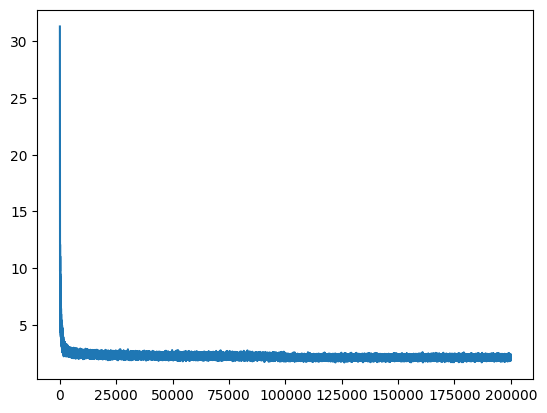

In [ ]:
stepi = []
lossi = []

batch_size = 128
for i in range(200000):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  # forward pass
  emb = C[Xtr[ix]]
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[ix])
  # backward pass
  for p in params: # note: this reset (to None, not 0) happens before loss.backward()
    p.grad = None
  loss.backward()
  # update
  learning_rate = 0.1 if i < 100000 else 0.01
  for p in params:
    p.data += -learning_rate * p.grad
  
  # tracking stats
  stepi.append(i)
  lossi.append(loss.item())

print(loss.item())
plt.plot(stepi, lossi)
# observations:
# batch size from 30 to X.shape[0], the resulting loss of 100 iters is basically the same, around 10

In [ ]:
# measuring loss on a specific fixed set instead of a random batch
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1119, grad_fn=<NllLossBackward0>)

In [ ]:
# measuring loss on a specific fixed set instead of a random batch
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1488, grad_fn=<NllLossBackward0>)

In [ ]:
print(logits[0])
p = F.softmax(logits, dim=1)[0]
print(p)
p[torch.multinomial(p, num_samples=1).item()]

tensor([-38.8487, -29.2852, -30.9345, -30.4129, -30.6204, -30.5478, -31.6204,
        -31.4023, -31.5383, -31.1708, -29.7186, -29.4484, -30.4082, -29.7561,
        -30.6727, -31.6539, -31.6254, -32.6874, -30.0405, -30.0915, -30.2392,
        -33.6654, -31.3115, -31.7813, -32.9425, -31.4655, -30.5488],
       grad_fn=<SelectBackward0>)
tensor([    0.0000,     0.1350,     0.0259,     0.0437,     0.0355,     0.0382,
            0.0131,     0.0163,     0.0142,     0.0205,     0.0875,     0.1147,
            0.0439,     0.0843,     0.0337,     0.0126,     0.0130,     0.0045,
            0.0634,     0.0603,     0.0520,     0.0017,     0.0178,     0.0111,
            0.0035,     0.0153,     0.0382], grad_fn=<SelectBackward0>)


tensor(0.0382, grad_fn=<SelectBackward0>)

In [ ]:
# sample from the model
for _ in range(10):
  out = []
  context = block_size * [0] # correct
  # context = [block_size * [0]] # correct: interpreted as training set with one example
  # the two contexts are the same after it's transformed by emb.view(-1, 30)
  while True:
    # forward pass
    emb = C[torch.tensor(context)]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)  # emb.view(-1, 30).dim() is determined by the number of params in .view(...)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1).item()
    out.append(ix)
    context = context[1:] + [ix]
    if ix == 0:
      break
  print("".join(itos[c] for c in out))

kaidyn.
nehudah.
kelynka.
cashban.
vivan.
zalay.
sys.
nyilia.
pailan.
jaklynn.


7.0621161460876465


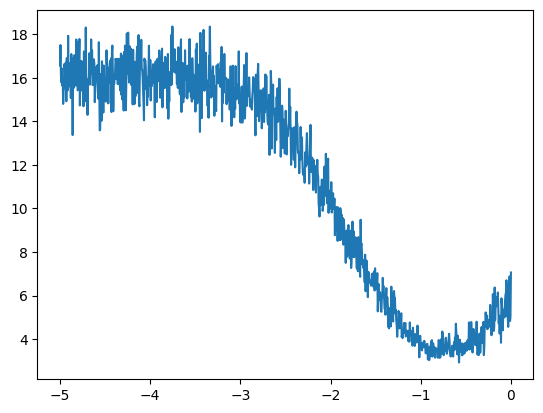

In [ ]:
# finding the right learning rate:
lre = torch.linspace(-5, 0, 1000) # learning rate exponent: lower and upper bounds -3 and 0 are determined manually
lrs = 10**lre # learning rate steps
# print(lrs)
lri = [] # used for plotting
lossi = [] # used for plotting

C = torch.randn((num_chars, 2))
W1 = torch.randn((6, nn))
b1 = torch.randn(nn)
W2 = torch.randn((nn, num_chars))
b2 = torch.randn(num_chars)
params = [C, W1, b1, W2, b2]
for p in params:
  p.requires_grad = True

batch_size = 100
for i in range(lre.shape[0]): # number of steps should be the same as the size of lre
  ix = torch.randint(0, X.shape[0], (batch_size,))
  emb = C[X[ix]]
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y[ix])
  for p in params:
    p.grad = None
  loss.backward()

  lr = lrs[i]
  for p in params:
    p.data += -lr * p.grad
  
  lri.append(lrs[i])
  lossi.append(loss.item())
print(loss.item())
# plt.plot(lri, lossi)
plt.plot(lre, lossi)  # plotting lre is better than lri bc lre is linear and hence more granularity afforded when we select

2.2642323970794678


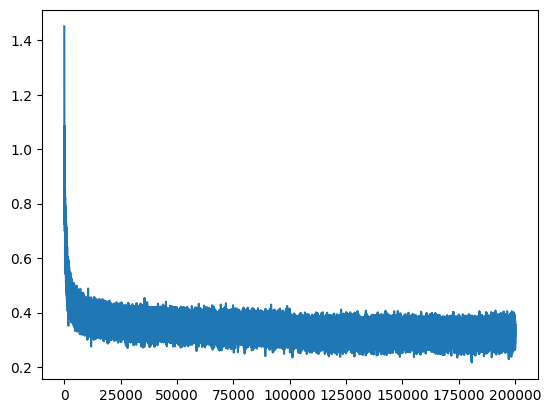

In [ ]:
# experimenting with different random param inits

nn = 300 # number of neurons
# params init
C = torch.randn((num_chars, 10)) # what is the requirement for the embedding? AN: there is none, the init value doesn't matter
W1 = torch.randn((30, nn)) # remember: the first element in size tuple represents the input size/dimension, meaning viewed as a matrix, each column contains the list of weights for a neuron
b1 = torch.randn(nn)
W2 = torch.randn((nn, num_chars))
b2 = torch.randn(num_chars)
params = [C, W1, b1, W2, b2]
for p in params:
  p.requires_grad = True

stepi = []
lossi = []

batch_size = 128
for i in range(200000):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  # forward pass
  emb = C[Xtr[ix]]
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[ix])
  # backward pass
  for p in params: # note: this reset (to None, not 0) happens before loss.backward()
    p.grad = None
  loss.backward()
  # update
  learning_rate = 0.1 if i < 100000 else 0.01
  for p in params:
    p.data += -learning_rate * p.grad
  
  # tracking stats
  stepi.append(i)
  lossi.append(loss.log10().item())

print(loss.item())
plt.plot(stepi, lossi)
# observations:
# batch size from 30 to X.shape[0], the resulting loss of 100 iters is basically the same, around 10

2.7226805686950684


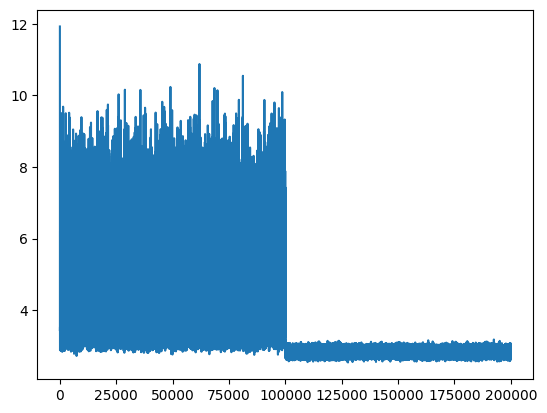

In [ ]:
# experimenting with different random param inits

nn = 300 # number of neurons
# params init
C = torch.rand((num_chars, 10)) # what is the requirement for the embedding? AN: there is none, the init value doesn't matter
W1 = torch.rand((30, nn)) # remember: the first element in size tuple represents the input size/dimension, meaning viewed as a matrix, each column contains the list of weights for a neuron
b1 = torch.rand(nn)
W2 = torch.rand((nn, num_chars))
b2 = torch.rand(num_chars)
params = [C, W1, b1, W2, b2]
for p in params:
  p.requires_grad = True

stepi = []
lossi = []

batch_size = 128
for i in range(200000):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  # forward pass
  emb = C[Xtr[ix]]
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[ix])
  # backward pass
  for p in params: # note: this reset (to None, not 0) happens before loss.backward()
    p.grad = None
  loss.backward()
  # update
  learning_rate = 0.1 if i < 100000 else 0.01
  for p in params:
    p.data += -learning_rate * p.grad
  
  # tracking stats
  stepi.append(i)
  lossi.append(loss.item())

print(loss.item())
plt.plot(stepi, lossi)
# observations:
# batch size from 30 to X.shape[0], the resulting loss of 100 iters is basically the same, around 10

2.149010419845581


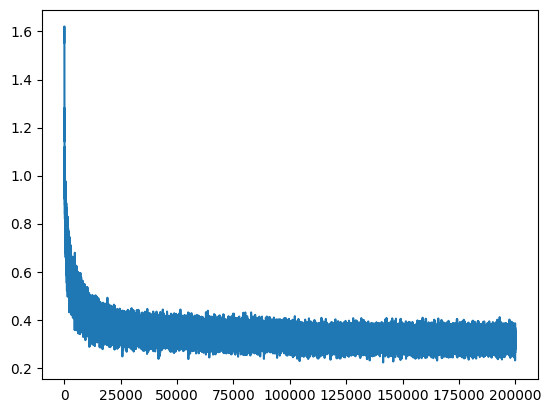

In [ ]:
# experimenting with different random param inits

nn = 300 # number of neurons
# params init
C = -2 + 4 * torch.rand((num_chars, 10)) # what is the requirement for the embedding? AN: there is none, the init value doesn't matter
W1 = -2 + 4 * torch.rand((30, nn)) # remember: the first element in size tuple represents the input size/dimension, meaning viewed as a matrix, each column contains the list of weights for a neuron
b1 = -2 + 4 * torch.rand(nn)
W2 = -2 + 4 * torch.rand((nn, num_chars))
b2 = -2 + 4 * torch.rand(num_chars)
params = [C, W1, b1, W2, b2]
for p in params:
  p.requires_grad = True

stepi = []
lossi = []

batch_size = 128
for i in range(200000):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  # forward pass
  emb = C[Xtr[ix]]
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[ix])
  # backward pass
  for p in params: # note: this reset (to None, not 0) happens before loss.backward()
    p.grad = None
  loss.backward()
  # update
  learning_rate = 0.1 if i < 100000 else 0.01
  for p in params:
    p.data += -learning_rate * p.grad
  
  # tracking stats
  stepi.append(i)
  lossi.append(loss.log10().item())

print(loss.item())
plt.plot(stepi, lossi)
# observations:
# batch size from 30 to X.shape[0], the resulting loss of 100 iters is basically the same, around 10

In [ ]:
C, W1, W2, b1, b2

(tensor([[ 0.1675, -0.5060, -0.1322,  0.9428,  0.4644,  0.4057, -0.7174,  0.0785,
          -0.1900, -0.4439],
         [-0.1940, -0.4904,  0.1914,  0.2994,  0.0613, -0.3122,  0.1715,  0.7307,
          -0.1039,  0.0082],
         [ 0.3114, -0.0467,  0.3851,  0.0918,  0.2841, -0.2495,  0.0095,  0.3575,
          -0.2427, -0.3704],
         [-0.4132, -0.5023,  0.5627, -0.6299, -0.3167,  0.4355,  0.6857, -0.9302,
          -0.2165,  0.5279],
         [ 0.2261,  0.1118,  0.2639, -0.0120,  0.4107, -0.0833, -0.1982,  0.2304,
          -0.1029, -0.1932],
         [-0.1154,  0.3286, -0.1469,  0.1248,  0.5251, -0.3555,  0.3892, -0.0022,
           0.4190,  0.3825],
         [-0.2654, -0.1038, -0.0458,  0.1250, -0.1199, -0.1982,  0.0282,  0.2076,
          -0.0854,  0.0245],
         [-0.2445, -0.0991, -0.2891,  0.0589, -0.1075, -0.0177, -0.0275,  0.3211,
          -0.1363, -0.0101],
         [-0.1900, -0.0426, -0.4606,  0.2720, -0.0711, -0.0484,  0.1932,  0.0574,
           0.1916, -0.0166],
 

2.8911519050598145


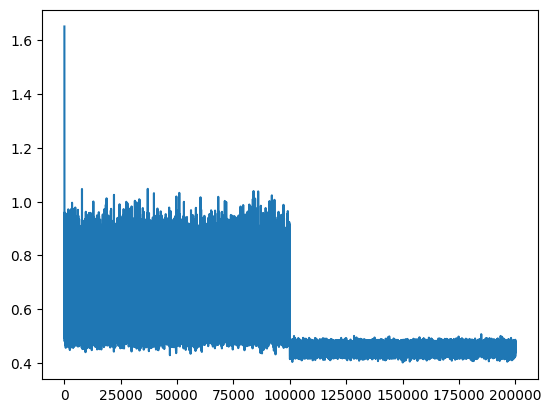

In [ ]:
# experimenting with different random param inits

nn = 300 # number of neurons
# params init
C = 4 * torch.rand((num_chars, 10)) # what is the requirement for the embedding? AN: there is none, the init value doesn't matter
W1 = 4 * torch.rand((30, nn)) # remember: the first element in size tuple represents the input size/dimension, meaning viewed as a matrix, each column contains the list of weights for a neuron
b1 = 4 * torch.rand(nn)
W2 = 4 * torch.rand((nn, num_chars))
b2 = 4 * torch.rand(num_chars)
params = [C, W1, b1, W2, b2]
for p in params:
  p.requires_grad = True

stepi = []
lossi = []

batch_size = 128
for i in range(200000):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  # forward pass
  emb = C[Xtr[ix]]
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[ix])
  # backward pass
  for p in params: # note: this reset (to None, not 0) happens before loss.backward()
    p.grad = None
  loss.backward()
  # update
  learning_rate = 0.1 if i < 100000 else 0.01
  for p in params:
    p.data += -learning_rate * p.grad
  
  # tracking stats
  stepi.append(i)
  lossi.append(loss.log10().item())

print(loss.item())
plt.plot(stepi, lossi)
# observations:
# batch size from 30 to X.shape[0], the resulting loss of 100 iters is basically the same, around 10

2.715059995651245
tensor([0.9461, 1.0423, 1.0329, 1.0295, 1.0209, 1.0472, 0.9009, 0.9478, 1.0251,
        1.0132, 1.0625, 0.9597, 0.9382, 0.9160, 0.9383, 1.0826, 0.8989, 0.9288,
        1.0058, 0.9196, 1.0853, 0.9308, 0.9949, 1.0612, 1.0198, 1.0071, 0.9370],
       requires_grad=True)


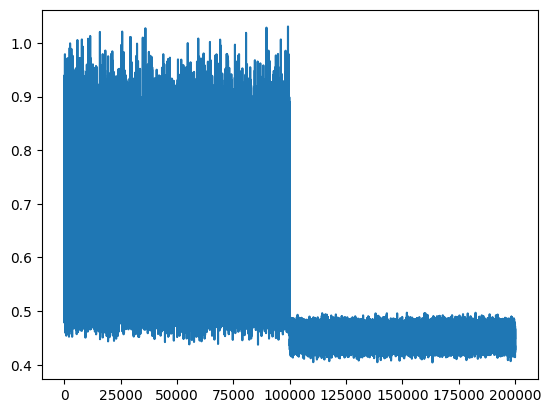

In [ ]:
# experimenting with different random param inits

nn = 300 # number of neurons
# params init
C = 0.9 + 0.2 * torch.rand((num_chars, 10)) # what is the requirement for the embedding? AN: there is none, the init value doesn't matter
W1 = 0.9 + 0.2 * torch.rand((30, nn)) # remember: the first element in size tuple represents the input size/dimension, meaning viewed as a matrix, each column contains the list of weights for a neuron
b1 = 0.9 + 0.2 * torch.rand(nn)
W2 = 0.9 + 0.2 * torch.rand((nn, num_chars))
b2 = 0.9 + 0.2 * torch.rand(num_chars)
params = [C, W1, b1, W2, b2]
for p in params:
  p.requires_grad = True

stepi = []
lossi = []

batch_size = 128
for i in range(200000):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  # forward pass
  emb = C[Xtr[ix]]
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[ix])
  # backward pass
  for p in params: # note: this reset (to None, not 0) happens before loss.backward()
    p.grad = None
  loss.backward()
  # update
  learning_rate = 0.1 if i < 100000 else 0.01
  for p in params:
    p.data += -learning_rate * p.grad
  
  # tracking stats
  stepi.append(i)
  lossi.append(loss.log10().item())

print(loss.item())
plt.plot(stepi, lossi)
print(b2)
# observations:
# batch size from 30 to X.shape[0], the resulting loss of 100 iters is basically the same, around 10

In [ ]:
C, W1, W2, b1, b2

(tensor([[1.0240, 0.9496, 0.9786, 0.9308, 0.9871, 0.9665, 1.0580, 1.0618, 0.9417,
          1.0603],
         [1.0733, 0.9495, 0.9551, 1.0030, 0.9998, 0.9699, 1.0925, 0.9447, 1.0475,
          0.9374],
         [1.0075, 0.9837, 1.0181, 1.0591, 0.9595, 0.9897, 1.0208, 0.9355, 0.9500,
          0.9264],
         [1.0637, 1.0600, 0.9772, 1.0391, 0.9167, 1.0715, 1.0491, 1.0970, 1.0457,
          0.9302],
         [1.0331, 1.0260, 1.0867, 0.9819, 1.0619, 1.0375, 1.0411, 0.9647, 1.0057,
          1.0937],
         [0.9942, 0.9246, 1.0128, 1.0649, 0.9694, 1.0839, 1.0563, 1.0710, 0.9614,
          0.9958],
         [1.0659, 1.0153, 1.0665, 0.9676, 1.0335, 0.9156, 0.9492, 0.9534, 1.0365,
          0.9993],
         [0.9716, 0.9547, 0.9685, 0.9326, 0.9310, 0.9816, 1.0293, 1.0080, 1.0497,
          1.0495],
         [0.9224, 1.0236, 1.0966, 1.0143, 1.0597, 0.9384, 0.9836, 0.9551, 0.9322,
          1.0079],
         [1.0385, 1.0059, 0.9945, 1.0035, 0.9568, 0.9874, 1.0807, 1.0121, 1.0407,
         

1.9880621433258057


(tensor([[ 0.6882,  0.1881,  0.3636, -1.0062, -0.3750, -0.6794,  0.3238,  0.1521,
          -0.6564,  0.1144],
         [-1.7019,  0.2905, -2.7774, -0.7554, -0.3245,  0.5470,  0.3174,  0.3259,
          -0.1350,  0.9852],
         [-0.8515,  1.9514,  1.4865,  2.3384,  0.3481, -1.4195, -0.9726, -0.0133,
          -0.7112,  1.4334],
         [ 1.8773, -1.4709, -0.3230,  0.3231,  3.0887,  0.7612, -0.4575,  0.9641,
          -1.4590,  1.4359],
         [-0.6051,  0.4514,  0.9090,  0.6603, -0.2036, -0.5736, -1.1507,  1.8102,
           1.0366,  0.2462],
         [-0.9143,  0.5255, -0.9504,  1.5763, -0.4138,  0.9671, -1.0301, -0.1950,
          -2.4145, -0.7879],
         [-0.3972,  1.4420,  0.8332, -0.1945,  1.1878, -0.7898,  0.1370, -0.0933,
           0.2578,  1.0663],
         [-1.2276, -1.0382,  0.9349,  0.8749,  1.4418, -2.5623,  0.7849,  1.0889,
           0.9482,  1.2283],
         [-1.1015,  0.7156,  0.7328, -0.7577,  0.5988,  2.7085,  0.8473, -2.1047,
          -0.6734,  0.5566],
 

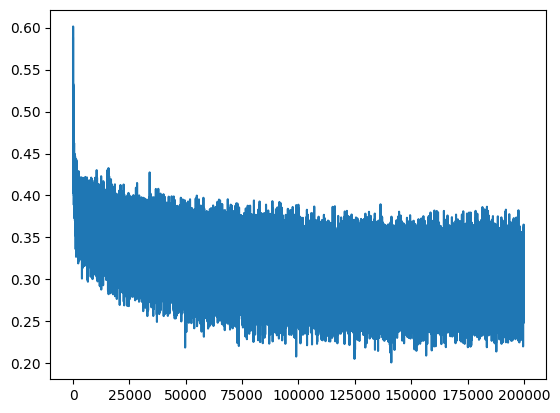

In [ ]:
# experimenting with different random param inits

nn = 300 # number of neurons
# params init
C = 0.1 + 0.2 * torch.rand((num_chars, 10)) # what is the requirement for the embedding? AN: there is none, the init value doesn't matter
W1 = 0.1 + 0.2 * torch.rand((30, nn)) # remember: the first element in size tuple represents the input size/dimension, meaning viewed as a matrix, each column contains the list of weights for a neuron
b1 = 0.1 + 0.2 * torch.rand(nn)
W2 = 0.1 + 0.2 * torch.rand((nn, num_chars))
b2 = 0.1 + 0.2 * torch.rand(num_chars)
params = [C, W1, b1, W2, b2]
for p in params:
  p.requires_grad = True

stepi = []
lossi = []

batch_size = 128
for i in range(200000):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  # forward pass
  emb = C[Xtr[ix]]
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[ix])
  # backward pass
  for p in params: # note: this reset (to None, not 0) happens before loss.backward()
    p.grad = None
  loss.backward()
  # update
  learning_rate = 0.1 if i < 100000 else 0.01
  for p in params:
    p.data += -learning_rate * p.grad
  
  # tracking stats
  stepi.append(i)
  lossi.append(loss.log10().item())

print(loss.item())
plt.plot(stepi, lossi)
C, W1, W2, b1, b2
# observations:
# batch size from 30 to X.shape[0], the resulting loss of 100 iters is basically the same, around 10

2.7767186164855957


(tensor([[-1.6523, -0.0517, -2.4928, -3.7297, -2.5255, -3.3747, -1.1887, -3.6089,
          -1.4182, -3.8872],
         [-0.4344, -3.0934, -3.0374, -2.8439, -1.3166, -2.2733, -0.7582, -3.3478,
          -0.2774, -1.2786],
         [-0.0553, -1.5684, -2.5350, -1.8247, -0.5810, -3.3834, -1.2508, -3.9980,
          -3.0105, -1.1502],
         [-1.0082, -1.2129, -1.2339, -3.3432, -1.0911, -3.6292, -3.7260, -0.5404,
          -3.5921, -0.7980],
         [-1.2396, -2.4483, -1.4003, -2.6082, -1.2707, -0.0563, -2.0797, -3.0115,
          -0.3991, -1.2199],
         [-1.0913, -0.9868, -3.5896, -0.7261, -1.9612, -0.2399, -2.5722, -3.4315,
          -3.1972, -0.1208],
         [-1.7483, -1.8202, -3.4655, -1.4718, -0.0768, -3.2623, -3.1721, -0.7783,
          -3.7951, -2.0419],
         [-1.3828, -2.8156, -1.7369, -2.6185, -3.5559, -2.3231, -1.8106, -3.9564,
          -2.5009, -1.8290],
         [-3.4074, -3.5634, -1.4276, -1.2348, -1.0235, -3.6030, -3.9178, -2.6389,
          -0.8413, -1.3706],
 

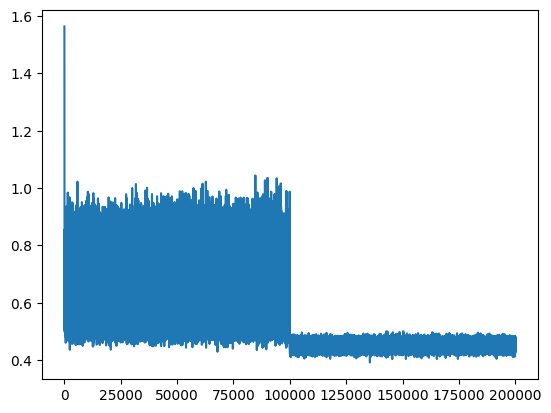

In [ ]:
# experimenting with different random param inits

nn = 300 # number of neurons
# params init
C = -4 + 4 * torch.rand((num_chars, 10)) # what is the requirement for the embedding? AN: there is none, the init value doesn't matter
W1 = -4 + 4 * torch.rand((30, nn)) # remember: the first element in size tuple represents the input size/dimension, meaning viewed as a matrix, each column contains the list of weights for a neuron
b1 = -4 + 4 * torch.rand(nn)
W2 = -4 + 4 * torch.rand((nn, num_chars))
b2 = -4 + 4 * torch.rand(num_chars)
params = [C, W1, b1, W2, b2]
for p in params:
  p.requires_grad = True

stepi = []
lossi = []

batch_size = 128
for i in range(200000):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  # forward pass
  emb = C[Xtr[ix]]
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[ix])
  # backward pass
  for p in params: # note: this reset (to None, not 0) happens before loss.backward()
    p.grad = None
  loss.backward()
  # update
  learning_rate = 0.1 if i < 100000 else 0.01
  for p in params:
    p.data += -learning_rate * p.grad
  
  # tracking stats
  stepi.append(i)
  lossi.append(loss.log10().item())

print(loss.item())
plt.plot(stepi, lossi)
C, W1, W2, b1, b2
# observations:
# batch size from 30 to X.shape[0], the resulting loss of 100 iters is basically the same, around 10